## We will separate this example into two part. One is truth record analysis which based on generator level information. The second is detector level analysis which based on the information passed detector simulation.


# In this example, we will rely on `pyjet` for jet clustering.
## pyjet: https://github.com/scikit-hep/pyjet



In [81]:
import uproot
import pyjet
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import sys, os
import importlib
import time

from BranchClass import *

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib import cm


## Define the class to fill particle information in to NumpyArray 

### User can use 
```
GenParticles = BrachGenParticles(file)
PID_all = GenParticles.PID
```
### to get all GenParticles PID array
### or
```
GenParticles = BrachGenParticles(file)
PID = GenParticles.PID_At(i)
```
### to get the GenParticles PID array in the ith event

## Define Function for Invariant Mass, Transverse Mass and Event_List



In [433]:
def M(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    return np.sqrt((e1+e2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2)


def MT(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2,missingET,missingETA,missingPHI):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    px_missing, py_missing = missingET*np.cos(missingPHI), missingET*np.sin(missingPHI)
    
    EllT = np.sqrt((px1+px2)**2 + (py1+py2)**2 +  M(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2)**2 )

    MT = np.sqrt( (EllT+missingET)**2 - (px1+px2+px_missing)**2 - (py1+py2+py_missing)**2 )
    
    return MT

def Event_List(GenParticle):
    print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
    ticks_1 = time.time()
    
    k = 0
    event_list = []
    
    for N in range(GenParticle.length):
        
        event_list_tmp = []
        event_list_b = []
        
        event_list_tmp.append([GenParticle.PT_At(N),  GenParticle.Eta_At(N), \
                               GenParticle.Phi_At(N), GenParticle.Mass_At(N), \
                               GenParticle.PID_At(N), GenParticle.Status_At(N),\
                               GenParticle.M1_At(N), GenParticle.M2_At(N),\
                               GenParticle.D1_At(N), GenParticle.D2_At(N)
                              ])

        event_list_tmp = np.array(event_list_tmp)
        
        bb_list_tmp = event_list_tmp[0][:,np.abs(event_list_tmp[0][4,:])==5]
        for i in range(len(bb_list_tmp[0])):
            if np.abs(GenParticle.PID_At(N)[int(bb_list_tmp[8][i])])!= 5 and np.abs(GenParticle.PID_At(N)[int(bb_list_tmp[9][i])]) != 5:
                event_list_b.append(bb_list_tmp[:,i])
                
#         print(event_list_b)
        
        # Ghost-association Method
        event_list_b[0][0] = np.array(event_list_b[0][0])*1E-8   #pt*1E-8
        event_list_b[1][0] = np.array(event_list_b[1][0])*1E-8   #mass*1E-8
        event_list_b[0][3] = np.array(event_list_b[0][3])*1E-8   #pt*1E-8
        event_list_b[1][3] = np.array(event_list_b[1][3])*1E-8   #mass*1E-8
#         print(len(event_list_b))
        

        event_list_tmp = event_list_tmp[0][:,event_list_tmp[0][5,:]==1]  # pick up stable final state particle 
        event_list_tmp = event_list_tmp[:,np.abs(event_list_tmp[4,:])!=12] # filter out neutrino
        event_list_tmp = event_list_tmp[:,np.abs(event_list_tmp[4,:])!=14] # filter out neutrino
        event_list_tmp = event_list_tmp[:,np.abs(event_list_tmp[4,:])!=16] # filter out neutrino
        event_list_tmp = np.concatenate((event_list_tmp, np.array(event_list_b[0]).reshape(10,1)), axis=1)
        event_list_tmp = np.concatenate((event_list_tmp, np.array(event_list_b[1]).reshape(10,1)), axis=1)
#         print(event_list_tmp[0:6,:].shape)
#         print(np.array(event_list_b).shape)
        
        event_list.append(event_list_tmp[0:6,:])
        

    ticks_2 = time.time()
    totaltime =  ticks_2 - ticks_1
    print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))
    
    return event_list
  


## Import File

In [83]:
# You will change this path according to your environment.
process_path = "/home/alan/MG5_Study_Group/monosbb/proc_sbb_lo_gq0p25_gx1p0_mzp2000_mhs90_mdm200/Events/run_01/tag_1_delphes_events.root"


try:
    monosbb = uproot.open(process_path)["Delphes;1"]

    print("All Files are loaded!")
    
except:
    print("Please Check Input Files")


All Files are loaded!


#  Print the Branch in the Delphes
### We can understand the ROOT file structure in this way.


In [426]:
monosbb.show()

## Load event via class

In [376]:
# importlib.reload(BranchClass)

GenParticle_monosbb = BranchGenParticles(monosbb)
Event_List_monosbb = Event_List(GenParticle_monosbb)
Jets = BranchJet(monosbb)
MissingET = BranchMissingET(monosbb)

Sun Dec 13 23:42:55 2020
Time Cost : 0.0521 min


# Let's do jet clustering!!
### We use ` np.core.records.fromarrays` to assign the name of kinematic variables and PID
### In `pyjet`, the data type are only 
`
np.dtype([('pT', 'f8'), ('eta', 'f8'), ('phi', 'f8'), ('mass', 'f8')])
`
### or (cluster(..., ep=True))
`
np.dtype([('E', 'f8'), ('px', 'f8'), ('py', 'f8'), ('pz', 'f8')])  
`
### In this example, we use `(pt, eta, phi and mass)`.
### After assigning the name for our each event list, the `pyjet.cluster` and `inclusive_jets` will help us do jet clustering.
`
sequence_cluster = pyjet.cluster(to_cluster, R = 0.4,p = -1)
jets_cluster = sequence_cluster.inclusive_jets(pt_min)
`
#### Variable: `R` is the cone size of the jet.
#### Variable: `p` is the jet clustering algorithm. `-1: anti-kt , 0: Cambridge-Aachen(C/A), 1: kt`
#### Variable: `pt_min` is the minimum jet's pt.



In [377]:
event_list = Event_List_monosbb
event_list_clustered = []

print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
ticks_1 = time.time()
for i in range(len(event_list)):

    to_cluster = np.core.records.fromarrays(event_list[i], 
                                             names="pT, eta, phi, mass, PID, Status",
                                             formats = "f8, f8, f8, f8, f8, f8")
    pt_min = 20
    sequence_cluster = pyjet.cluster(to_cluster, R = 0.5, p = -1) # p = -1: anti-kt , 0: Cambridge-Aachen(C/A), 1: kt
    jets_cluster = sequence_cluster.inclusive_jets(pt_min)
    event_list_clustered.append(jets_cluster)

ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))

Sun Dec 13 23:42:58 2020
Time Cost : 0.6379 min


# Print jets in the Nth event

In [379]:
N = 0

for i, jets in enumerate(event_list_clustered[N]):
    print("{}".format("No." +str(i)+" Jet's Information"))
    print(jets)
    print("-------------------------------------------------------------------------")
    print("{:^19} {:^20} ".format("Constituent's PID","Constituent's Four Momentum"))
    print("-------------------------------------------------------------------------")
    
    for constituent in jets: # get constituent in each "jet_element"
        print("{:^19} {} ".format(int(constituent.PID), constituent))
    print("-------------------------------------------------------------------------")

# Print the Truth Record in an Event

In [25]:
GenParticle = GenParticle_monosbb


print("There are {} information in this event.".format(len(GenParticle.Status[0])))
print("GenParticle Information")
print("{:^5}{:^7}{:^7}{:^7}{:^7}{:^7}{:^7}{:^8}{:^8}{:^8}{:^8}".format("#","Status","PID", "M1", "M2", "D1", "D2", "PT", "Eta","Phi", "Mass"))

index = 0 ## which event you want to print out
k = 0
for j in range(len(GenParticle.Status_At(index))):
    
#     if GenParticle.Status_At(index)[j] == 1: ##Selet the Stable Final State Particles

        print("{:^5}{:^7}{:^7}{:^7}{:^7}{:^7}{:^7}{:^8.2}{:^8.2}{:^8.2}{:^8.2}".format( \
        j, GenParticle.Status_At(index)[j],  GenParticle.PID_At(index)[j], GenParticle.M1_At(index)[j], GenParticle.M2_At(index)[j],
         GenParticle.D1_At(index)[j], GenParticle.D2_At(index)[j],  GenParticle.PT_At(index)[j],  GenParticle.Eta_At(index)[j], GenParticle.Phi_At(index)[j], GenParticle.Mass_At(index)[j]))



# monosbb Events' Selection From Truth Record
### We want to make plot for the inavriant mass distribution of dijet from two b quark or from two dark matters ($\chi$).
### We require the event must contain 2 jets from dark matters and additional 2 jets from two b quarks.

In [436]:
M_JJ_dark, M_JJ_bb = [], []
PT_J_Zp, PT_J_Hs = [], []
event_sele = []

for N in range(len(event_list_clustered)):
    
    jet_chi, jet_b = [], []

    for i, element in enumerate(event_list_clustered[N]):

        for constituent in element:
            if constituent.PID == 1000022:
                jet_chi.append(element)
        
        for constituent in element:
            if abs(constituent.PID) == 5:
                jet_b.append(element)
                
    if len(jet_chi) == 2 and len(jet_b) == 2:  # require 2 jets from dark matters and additional 2 jets from two b quarks
        M_JJ_dark.append(M(jet_chi[0].pt,jet_chi[0].eta,jet_chi[0].phi,jet_chi[0].mass,
                          jet_chi[1].pt,jet_chi[1].eta,jet_chi[1].phi,jet_chi[1].mass))
        M_JJ_bb.append(M(jet_b[0].pt,jet_b[0].eta,jet_b[0].phi,jet_b[0].mass,
                          jet_b[1].pt,jet_b[1].eta,jet_b[1].phi,jet_b[1].mass))
        event_sele.append(N)

print("There are {} events passed this dijet selection.".format(len(event_sele)))
    

There are 7295 events passed this dijet selection.


## Example 1: Plot in differential number of event

In [410]:
def HIST(process, length, title, colors, linestyle,xpo=1,ypo=1):
    hist, bins = np.histogram(process, bins=length)
    plt.step(bins[:-1], hist.astype(np.float32) / hist.sum(), linestyle ,color= colors ,where='mid',linewidth=5, alpha=0.7, label=title[i])
#     plt.legend(bbox_to_anchor=(xpo, ypo),ncol=1,fontsize=30, edgecolor = "w",fancybox=False, framealpha=0)
    plt.legend(loc="best",ncol=1,fontsize=25, edgecolor = "w",fancybox=False, framealpha=0)
    
title = ["leading Jet", "Subleading Jet"]
colors = ["green","red"]
linestyle = ["-","-."]


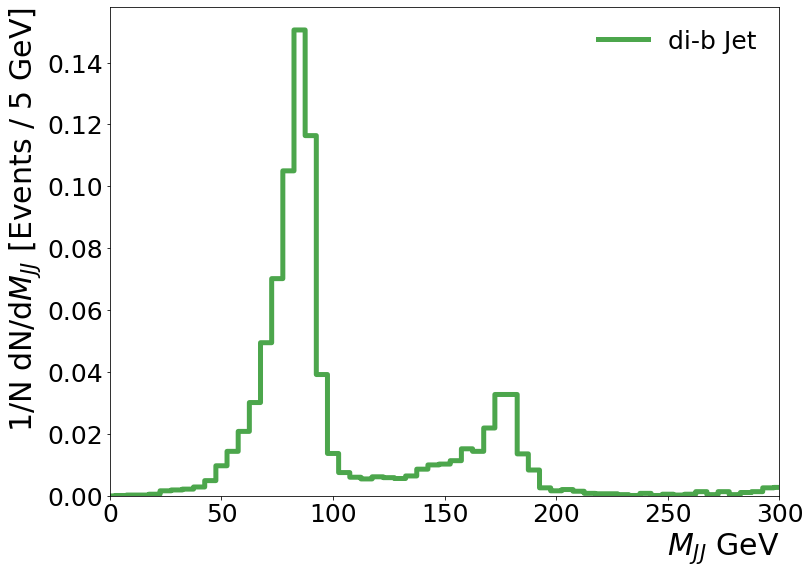

In [423]:
M_j = [M_JJ_bb]

fig, ax = plt.subplots(1,1, figsize=(12,9))
for i, process in enumerate(M_j):
    length = np.linspace(0,3000,601)
    HIST(process, length, ["di-b Jet"],colors[i],linestyle[i])
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plt.xlim((0,300))
    plt.xlabel("$M_{JJ}$ GeV", fontsize=30,horizontalalignment='right',x=1) 

    
plt.ylim((0.))
plt.ylabel("1/N dN/d$M_{JJ}$ [Events / 5 GeV]", fontsize=30, horizontalalignment='right',y=1)
plt.show()    
    

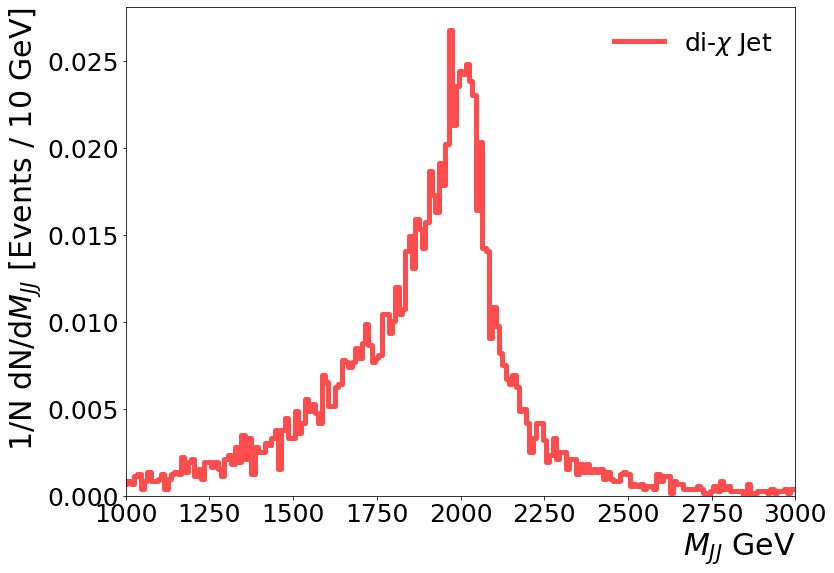

In [434]:
M_j = [M_JJ_dark]

fig, ax = plt.subplots(1,1, figsize=(12,9))
for i, process in enumerate(M_j):
    length = np.linspace(0,3000,301)
    HIST(process, length, ["di-$\chi$ Jet"],"red",linestyle[i])
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plt.xlim((1000,3000))
    plt.xlabel("$M_{JJ}$ GeV", fontsize=30,horizontalalignment='right',x=1) 

    
plt.ylim((0.))
plt.ylabel("1/N dN/d$M_{JJ}$ [Events / 10 GeV]", fontsize=30, horizontalalignment='right',y=1)
plt.show()    

# monosbb Events' Selection From Reconstructed Record
###  We want to make plot for the inavriant mass distribution of two reconstructed jets.
### We need to select the events with # of jet >=2 and apply further selection in missingET.

In [431]:
dijet_invariantmass = []
missing_mass = []
survived_list = []
for i in range(Jets.length):
    if len(Jets.PT_At(i)) < 2:
        continue
        
    if len(MissingET.MET_At(i)) < 1:
        continue

    if MissingET.MET_At(i)[0] < 300 or MissingET.MET_At(i)[0] > 500:
        continue


    dijet_invariantmass.append(M(Jets.PT_At(i)[0],Jets.Eta_At(i)[0],Jets.Phi_At(i)[0],Jets.Mass_At(i)[0],
                                 Jets.PT_At(i)[1],Jets.Eta_At(i)[1],Jets.Phi_At(i)[1],Jets.Mass_At(i)[1]))

    survived_list.append(i)

print("There are {} MC events.".format(len(dijet_invariantmass)))

There are 1650 MC events.


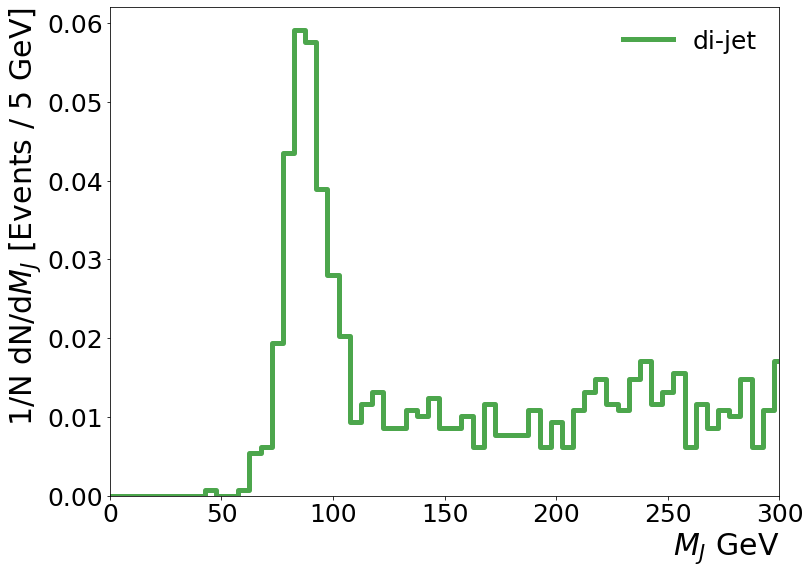

In [432]:
M_j = [dijet_invariantmass]

fig, ax = plt.subplots(1,1, figsize=(12,9))
for i, process in enumerate(M_j):
    length = np.linspace(0,500,101)
    HIST(process, length, ["di-jet"] ,colors[i],linestyle[i])
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plt.xlim((0,300))
    plt.xlabel("$M_{J}$ GeV", fontsize=30,horizontalalignment='right',x=1) 

    
plt.ylim((0.))
plt.ylabel("1/N dN/d$M_{J}$ [Events / 5 GeV]", fontsize=30, horizontalalignment='right',y=1)
plt.show()    